In [1]:
# Goal of this notebook is to implement the dynamical model of Neggers et al. (2006).
# Figure 4 of Neggers et al. (2006) is reproduced, but the equilibrium values do not coincide with theirs.
# They coincides with those published by Youtong Zheng here https://github.com/youtongzheng/Neggers_2006.

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# Define some meteorological functions from pycoare.
def qsat(t,p):
    """
    usage: es = qsat(t,p)
    Returns saturation vapor pressure es (mb) given t(C) and p(mb).
    After Buck, 1981: J.Appl.Meteor., 20, 1527-1532
    Returns ndarray float for any numeric object input.
    """
    from numpy import copy, asarray, exp

    t2 = copy(asarray(t, dtype=float))  # convert to ndarray float
    p2 = copy(asarray(p, dtype=float))
    es = 6.1121 * exp(17.502 * t2 / (240.97 + t2))
    es = es * (1.0007 + p2 * 3.46e-6)
    return es

def qsea(sst,p):
    """
    usage: qs = qsea(sst,p)
    Returns saturation specific humidity (g/kg) at sea surface
    given sst(C) and p(mb) input of any numeric type.
    Returns ndarray float for any numeric object input.
    """
    ex = qsat(sst,p) # returns ex as ndarray float
    es = ex#0.98 * ex # This is the correction for the effect of salinity, which we remove now
    qs = 622*es/(p-0.378*es) # saturation specific humidity
    return qs

In [3]:
def neggers_et_al_2006(t,y,V,SST,D,q_free,th_free,ps):
    """
    Subscript s denotes surface values, b stands for buoyancy, which is associated with the virtual potential
    temperature (theta_v), th indicates the liquid water potential temperature (theta_l) and q the total specific
    humidity (q_t).
    """
    # Define some constants.
    delta_z = 100.0 # [m]
    Cqs = 0.0012 # [1], surface exchange coefficient for q
    Cths = 0.0012 # [1], surface exchange coefficient for theta
    Cqc = 0.1 # [1], cloud level exchange coefficient for q
    Cthc = 0.03 # [1], cloud level exchange coefficient for theta
    Le = 2.5e6 # [J/kg], latent heat of vaporization 
    cpd  = 1004.67 # [J/K/kg], dry air specific heat at constant pressure
    Rd = 287.1 # [J/K/kg], dry air gas constant
    # air density is supposed to be constant and equal to 1...
    beta = 0.36
    gamma = 1.55
    g = 9.81 # [m/s2], acceleration due to gravity
    
    ### Define some forcing variables for the BOMEX example -> this will be given as input parameters.
    #V = 8.75 # [m/s], large scale horizontal wind
    #SST = 300.4 # [K], sea surface temperature
    #D = 4.3e-6 # [1/s], large scale divergence
    #q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
    #th_free = 308 # [K], free tropospheric liquid virtual potential temperature
    F_advq = -1.2e-3/86400 # [kg/kg/s]
    F_advth = 0.0/86400 # [K/s]
    F_rad = -2.0/86400 # [K/s]
    #ps = 1015 # [hPa], surface pressure
    ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
    q_s = qsea(SST-273.15,ps)*1e-3 # [kg/kg], surface total specific humidity (saturation value)
    th_s = SST*(ref_p/ps)**(Rd/cpd) # [K], surface liquid water potential temperature, assuming no liquid water at the surface
    
    ### Define some diagnostic variables.
    # Entrainment.
    q_flux_s = V*Cqs*(q_s-y[1]) # total specific humidity flux at the surface
    th_flux_s = V*Cths*(th_s-y[2]) # liquid water potential temperature flux at the surface
    thv_flux_s = (1+0.61*q_s)*th_flux_s + 0.61*th_s*q_flux_s # surface virtual potential temp flux
    delta_q = Cqc*(q_free-y[1])
    delta_th = Cthc*(th_free-y[2])
    delta_thv = delta_th + 0.61*(y[1]*delta_th + y[2]*delta_q + delta_q*delta_th)
    E = 0.2*thv_flux_s/delta_thv
    # Mass flux.
    thv0 = y[2]*(1+0.61*y[1]) # [K], ABL virtual potential temperature
    b_flux_s = g*thv_flux_s/thv0 # surface buoyancy flux
    w_star = (y[0]*b_flux_s)**(1/3) # m/s, Deardorff convective velocity scale. 5th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(ps/ref_p)**(Rd/cpd)*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 4th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 3rd try
#    w_star = (g*y[0]*thv_flux_s/y[2])**(1/3) # m/s, Deardorff convective velocity scale. 2nd try
#    w_star = (g*y[0]*thv_flux_s/th_s)**(1/3) # m/s, Deardorff convective velocity scale. 1st try
    
    T0 = y[2]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
    T_h = T0-g/cpd*y[0] # [K], air temperature at h following a dry adiabat.
    p_h = ps*100*(1-g*y[0]/(T0*cpd))**(cpd/Rd) # [Pa], air pressure at h with p=rho*R*T; dp/dz=-rho*g; dtheta/dz=0 
    e_sat_h = qsat(T_h-273.15,p_h/100)*100 # [Pa], saturation vapor pressure at h.
    q_sat = 0.622*e_sat_h/(p_h-0.378*e_sat_h) # [kg/kg], saturation specific humidity at h.
   
    sigma_q = np.sqrt(-q_flux_s*delta_q*y[0]/(w_star*delta_z))
    area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)
    M = area_c*w_star
    
    ### Define the equations to be solved.
    dh_dt = E - D*y[0] - M 
    dq_dt = (q_flux_s + E*delta_q)/y[0] + F_advq
    dth_dt = (th_flux_s + E*delta_th)/y[0] + F_advth + F_rad
    
    #print(area_c)
    #print((y[1]-q_sat)*1e3)
    #print(sigma_q*1e3)
    #print(w_star)
    #print((y[1]-q_sat)/sigma_q)
    area_c_ext.append(area_c)
    w_star_ext.append(w_star)
    M_ext.append(M)
    E_ext.append(E)
    sigma_q_ext.append(sigma_q)
    LHF_ext.append(q_flux_s*Le)
    
    return dh_dt, dq_dt, dth_dt

In [6]:
# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2]

# Input parameters
V = 8.75 # [m/s], large scale horizontal wind
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
ps = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0
area_c_ext = []
w_star_ext = []
M_ext = []
E_ext = []
sigma_q_ext = []
LHF_ext = []
sol = solve_ivp(neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps))#, t_eval=t_eval)

<ipython-input-3-9fcbf52a3e7b>:60: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


equilibrium h = 557.8276050713392 m
equilibrium q = 16.037547636702545 g/kg
equilibrium th = 299.1694613143642 K
equilibrium a$_c$ = 7.996415070198065%
equilibrium w$\star$ = 0.6018309511538078 m/s


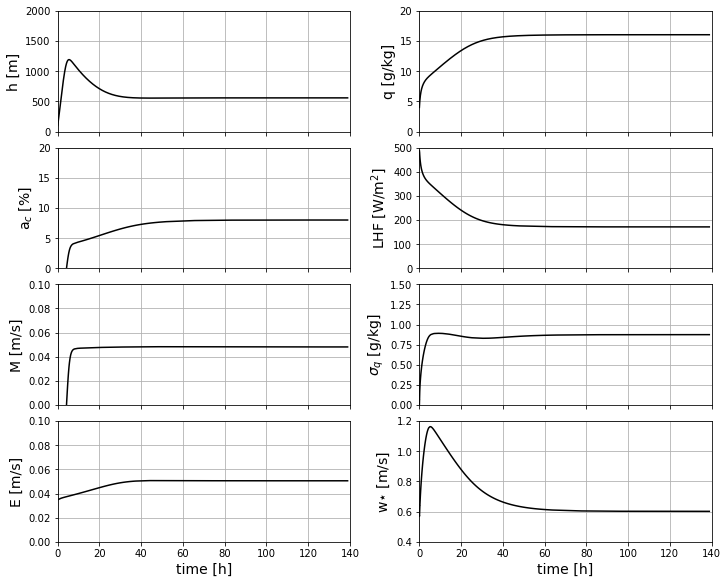

In [7]:
# Plots for a single run.
h = sol.y[0]
q = sol.y[1]
th = sol.y[2]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final = np.max(sol.t)
dt = t_final/3600/len(E_ext) # [h]
time_ext = np.arange(len(E_ext))*dt

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(area_c_ext[-1]*100)+'%')
print('equilibrium w$\star$ = '+str(w_star_ext[-1])+' m/s')

fig, ax = plt.subplots(4,2,figsize=(10,8),sharex=True,constrained_layout=True)

ax[0,0].plot(sol.t/3600,h,'k')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()

ax[0,1].plot(sol.t/3600,q*1e3,'k')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].set_ylim(0,20)
ax[0,1].grid()

#plt.plot(sol.t/3600,sol.y[2],'.')
#plt.ylabel('th [K]',fontsize=14)
#plt.xlabel('time [h]',fontsize=14)
#plt.grid()
#plt.show()

ax[1,0].plot(time_ext,np.array(area_c_ext)*100,'k')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()

ax[1,1].plot(time_ext,np.array(LHF_ext),'k')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
ax[1,1].set_ylim(0,500)
ax[1,1].grid()

ax[2,0].plot(time_ext,np.array(M_ext),'k')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(time_ext,np.array(sigma_q_ext)*1e3,'k')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

ax[3,0].plot(time_ext,np.array(E_ext),'k')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].plot(time_ext,np.array(w_star_ext),'k')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[3,0].set_xlabel('time [h]',fontsize=14)
ax[3,1].set_xlabel('time [h]',fontsize=14)
ax[3,0].set_xlim(0,140)
ax[3,1].set_xlim(0,140)

# Define the variables with constant V(_mag), CV
h_CV = h
q_CV = q
area_c_ext_CV = area_c_ext
LHF_ext_CV = LHF_ext
M_ext_CV = M_ext
sigma_q_ext_CV = sigma_q_ext
E_ext_CV = E_ext
w_star_ext_CV = w_star_ext

In [52]:
# Now test the dependence of the solution to some external parameters.

# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2]

# Input parameters
V = 8.75 # [m/s], large scale horizontal wind
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
ps = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

# Neggers et al. (2006) forcing and equilibrium values.
V_N06 = 8.75 # [m/s], large scale horizontal wind
SST_N06 = 300.4 # [K], sea surface temperature
D_N06 = 4.3e-6 # [1/s], large scale divergence
q_free_N06 = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free_N06 = 308 # [K], free tropospheric liquid virtual potential temperature
ps_N06 = 1015 # [hPa], surface pressure
q_s_N06 = qsea(SST_N06-273.15,ps_N06)*1e-3

h_N06 = 692 # m/s
q_N06 = 15 # g/kg
#th_N06 = 
a_c_N06 = 4.3 # %
w_star_N06 = 0.75 # m/s
M_N06 = 0.032 # m/s
h_N06 = 692 # m/s
q_N06 = 15 # g/kg
#th_N06 = 
a_c_N06 = 4.3 # %
w_star_N06 = 0.75 # m/s
M_N06 = 0.032 # m/s

# Set a single parameter to change. Remember to change the name of the variable in the following for loop.
str_variable = 'V'; list_of_values = np.arange(5,15,1); str_units = 'm/s'; x_N06 = V_N06
#str_variable = 'SST'; list_of_values = np.arange(300,306,0.5); str_units = 'K'; x_N06 = SST_N06
#str_variable = 'D'; list_of_values = np.arange(2.5,6.5,0.25)*1e-6; str_units = '1/s'; x_N06 = D_N06
#str_variable = 'q_free'; list_of_values = np.arange(2.0e-3,4.0e-3,0.2e-3); str_units = 'kg/kg'; x_N06 = q_free_N06
#str_variable = 'th_free'; list_of_values = np.arange(302,312); str_units = 'K'; x_N06 = th_free_N06
#str_variable = 'ps'; list_of_values = np.arange(1000,1030,5); str_units = 'hPa'; x_N06 = ps_N06

#---------
h_eq = np.zeros((len(list_of_values),))
q_eq = h_eq.copy()
th_eq = h_eq.copy()
a_c_eq = h_eq.copy()
w_star_eq = h_eq.copy()
M_eq = h_eq.copy()

for jj,V in enumerate(list_of_values):
    ii=0
    area_c_ext = []
    w_star_ext = []
    M_ext = []
    sol = solve_ivp(neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps))#, t_eval=t_eval)
    h_eq[jj] = sol.y[0][-1]
    q_eq[jj] = sol.y[1][-1]
    th_eq[jj] = sol.y[2][-1]
    a_c_eq[jj] = area_c_ext[-1]
    w_star_eq[jj] = w_star_ext[-1]
    M_eq[jj] = M_ext[-1]
    print(str(np.round(100*(jj+1)/len(list_of_values)))+' percent')
    print('---------------------------------------')

<ipython-input-25-f2b21580af1e>:61: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


10.0 percent
---------------------------------------
20.0 percent
---------------------------------------
30.0 percent
---------------------------------------
40.0 percent
---------------------------------------
50.0 percent
---------------------------------------
60.0 percent
---------------------------------------
70.0 percent
---------------------------------------
80.0 percent
---------------------------------------
90.0 percent
---------------------------------------
100.0 percent
---------------------------------------


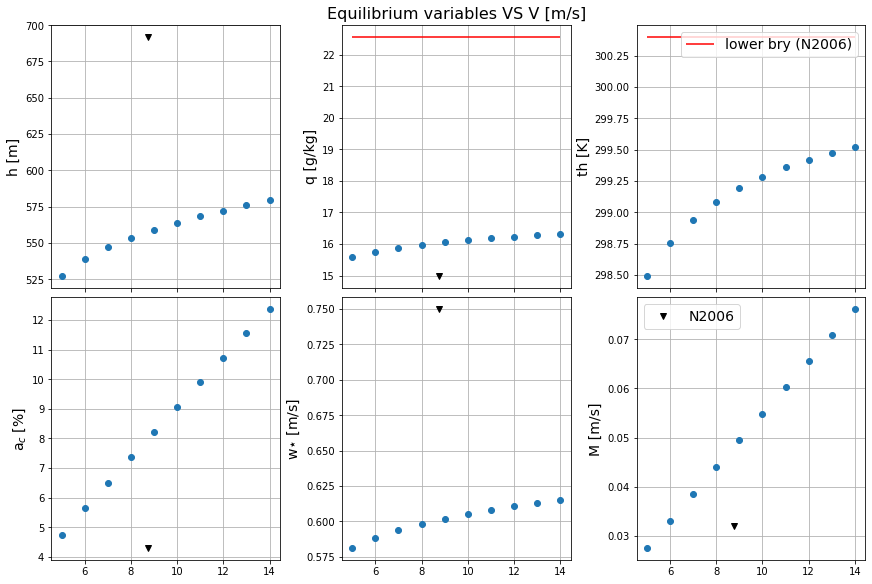

In [53]:
fig, ax = plt.subplots(2,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o')
ax[0,0].grid()
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].plot(x_N06,h_N06,'kv')

ax[0,1].plot(list_of_values,q_eq*1e3,'o')
ax[0,1].grid()
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
ax[0,1].plot(x_N06,q_N06,'kv')

ax[0,2].plot(list_of_values,th_eq,'o')
ax[0,2].grid()
ax[0,2].set_ylabel('th [K]',fontsize=14)
ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)

ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].plot(x_N06,a_c_N06,'kv')

ax[1,1].plot(list_of_values,w_star_eq,'o')
ax[1,1].grid()
ax[1,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[1,1].plot(x_N06,w_star_N06,'kv')

ax[1,2].plot(list_of_values,M_eq,'o')
ax[1,2].grid()
ax[1,2].set_ylabel('M [m/s]',fontsize=14)
ax[1,2].plot(x_N06,M_N06,'kv',label='N2006')
ax[1,2].legend(fontsize=14)

ax[0,1].set_title('Equilibrium variables VS '+str_variable+' ['+str_units+']',fontsize=16)

figure_name = 'equilibrium_variables_dependence_on_' + str_variable + '.png'
plt.savefig(figure_name,bbox_inches='tight')

In [70]:
a = 6/np.sqrt(1+np.tan(22.5*np.pi/180)**2)
print(a)

5.54327719506772


In [73]:
b = np.tan(22.5*np.pi/180)*a
print(b)

2.296100594190538


In [74]:
np.sqrt(5.5**2+2.3**2)

5.961543424315552

In [12]:
def prt_dyer74(zL):
    if zL>0:
        return 1
    else:
        return 1/(1-16*zL)**0.25

In [13]:
def neggers_et_al_2006_stevens_et_al_2002(t,y,SST,D,q_free,th_free,ps,f,U_free,V_free,we):
    """
    Subscript s denotes surface values, b stands for buoyancy, which is associated with the virtual potential
    temperature (theta_v), th indicates the liquid water potential temperature (theta_l) and q the total specific
    humidity (q_t).
    A bulk model of the wind speed is added starting from the Stevens et al., JCli (2002) paper
    "Entrainment, Rayleigh friction, and boundary layer winds over the tropical Pacific"
    y[3] is U, the zonal bulk wind component
    y[4] is V, the meridional bulk wind component
    V_mag is the magnitude of the bulk wind = np.sqrt(y[3]**2+y[4]**2)
    """
    # Define some constants.
    delta_z = 100.0 # [m]
    Cqs = 0.0012 # [1], surface exchange coefficient for q
    Cths = 0.0012 # [1], surface exchange coefficient for theta
    Cqc = 0.1 # [1], cloud level exchange coefficient for q
    Cthc = 0.03 # [1], cloud level exchange coefficient for theta
    Le = 2.5e6 # [J/kg], latent heat of vaporization 
    cpd  = 1004.67 # [J/K/kg], dry air specific heat at constant pressure
    Rd = 287.1 # [J/K/kg], dry air gas constant
    # air density is supposed to be constant and equal to 1...
    beta = 0.36
    gamma = 1.55
    g = 9.81 # [m/s2], acceleration due to gravity
    CD = 1/900. # drag coefficient.
    
    ### Define some forcing variables for the BOMEX example -> this will be given as input parameters.
    #V = 8.75 # [m/s], large scale horizontal wind
    #SST = 300.4 # [K], sea surface temperature
    #D = 4.3e-6 # [1/s], large scale divergence
    #q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
    #th_free = 308 # [K], free tropospheric liquid virtual potential temperature
    F_advq = -1.2e-3/86400 # [kg/kg/s]
    F_advth = 0.0/86400 # [K/s]
    F_rad = -2.0/86400 # [K/s]
    #ps = 1015 # [hPa], surface pressure
    ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
    q_s = qsea(SST-273.15,ps)*1e-3 # [kg/kg], surface total specific humidity (saturation value)
    th_s = SST*(ref_p/ps)**(Rd/cpd) # [K], surface liquid water potential temperature, assuming no liquid water at the surface
    
    ### Define some diagnostic variables.
    # Entrainment.
    V_mag = np.sqrt(y[3]**2+y[4]**2) # [m/s], bulk wind speed.
    q_flux_s = V_mag*Cqs*(q_s-y[1]) # total specific humidity flux at the surface
    th_flux_s = V_mag*Cths*(th_s-y[2]) # liquid water potential temperature flux at the surface
    thv_flux_s = (1+0.61*q_s)*th_flux_s + 0.61*th_s*q_flux_s # surface virtual potential temp flux, <w'theta_v'>    # Entrainment.
    delta_q = Cqc*(q_free-y[1])
    delta_th = Cthc*(th_free-y[2])
    delta_thv = delta_th + 0.61*(y[1]*delta_th + y[2]*delta_q + delta_q*delta_th)
    E = 0.2*thv_flux_s/delta_thv
    # Mass flux.
    thv0 = y[2]*(1+0.61*y[1]) # [K], ABL virtual potential temperature
    b_flux_s = g*thv_flux_s/thv0 # surface buoyancy flux
    w_star = (y[0]*b_flux_s)**(1/3) # m/s, Deardorff convective velocity scale. 5th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(ps/ref_p)**(Rd/cpd)*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 4th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 3rd try
#    w_star = (g*y[0]*thv_flux_s/y[2])**(1/3) # m/s, Deardorff convective velocity scale. 2nd try
#    w_star = (g*y[0]*thv_flux_s/th_s)**(1/3) # m/s, Deardorff convective velocity scale. 1st try    
    T0 = y[2]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
    T_h = T0-g/cpd*y[0] # [K], air temperature at h following a dry adiabat.
    p_h = ps*100*(1-g*y[0]/(T0*cpd))**(cpd/Rd) # [Pa], air pressure at h with p=rho*R*T; dp/dz=-rho*g; dtheta/dz=0 
    e_sat_h = qsat(T_h-273.15,p_h/100)*100 # [Pa], saturation vapor pressure at h.
    q_sat = 0.622*e_sat_h/(p_h-0.378*e_sat_h) # [kg/kg], saturation specific humidity at h.   
    sigma_q = np.sqrt(-q_flux_s*delta_q*y[0]/(w_star*delta_z))
    area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)
    M = area_c*w_star
    # Entrainment for the horizontal momentum.
    u_star = V_mag*np.sqrt(CD) # [m/s], Friction velocity, assuming air density equal to 1... We can correct this!
    L = - u_star**3/(0.4*b_flux_s)# [m], Monin-Obukhov length
    print
    zL = 10/L # [1], ratio z/L, we assume z=10 m as a reference height: we are interested in the surface stability
    we_dyn = E*prt_dyer74(zL)
    print(we_dyn)
    
    ### Define the equations to be solved.
    dh_dt = E - D*y[0] - M 
    dq_dt = (q_flux_s + E*delta_q)/y[0] + F_advq
    dth_dt = (th_flux_s + E*delta_th)/y[0] + F_advth + F_rad
    dU_dt = f*(y[4]-V_free)-y[3]*(CD*V_mag+we_dyn)/y[0]+U_free*we_dyn/y[0]
    dV_dt = -f*(y[3]-U_free)-y[4]*(CD*V_mag+we_dyn)/y[0]+V_free*we_dyn/y[0]
    
    #print(area_c)
    #print((y[1]-q_sat)*1e3)
    #print(sigma_q*1e3)
    #print(w_star)
    #print((y[1]-q_sat)/sigma_q)
    area_c_ext.append(area_c)
    w_star_ext.append(w_star)
    M_ext.append(M)
    E_ext.append(E)
    sigma_q_ext.append(sigma_q)
    LHF_ext.append(q_flux_s*Le)
    
    return dh_dt, dq_dt, dth_dt, dU_dt, dV_dt

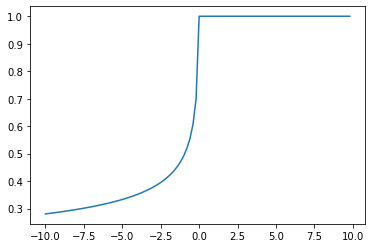

In [11]:
def prt_dyer74(zL):
    if zL>0:
        return 1
    else:
        return 1/(1-16*zL)**0.25

zL = np.arange(-10,10,0.2)
Prt = np.zeros((len(zL),))
for ii,z in enumerate(zL):
    Prt[ii] = prt_dyer74(z)
    
plt.plot(zL,Prt)

In [14]:
Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)
U_free = -5.5 # [m/s], free zonal wind (above the ABL).
V_free = -2.3 # [m/s], free meridional wind (above the ABL).
we = 0.005 # [m/s], entrainment velocity for the horizontal velocity.

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2,U_free,V_free]

# Input parameters
#V = 8.75 # [m/s], large scale horizontal wind -> no longer needed!
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
ps = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0
area_c_ext = []
w_star_ext = []
M_ext = []
E_ext = []
sigma_q_ext = []
LHF_ext = []
sol = solve_ivp(neggers_et_al_2006_stevens_et_al_2002, time, y0, dense_output=True, max_step=dt_max, args=(SST,D,q_free,th_free,ps,f,U_free,V_free,we))#, t_eval=t_eval)

<ipython-input-13-7c1331a09213>:65: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


0.012891204578781578
0.01288750116948529
0.012891145005302185
0.012891115196487285
0.012890966590981899
0.012890940923059126
0.012890907925975323
0.01289090670438314
0.01289069567488809
0.0128905902097676
0.012890062942611576
0.01288996923538508
0.01288985211397324
0.012889852114173926
0.012887744105625073
0.012886695047465235
0.01288145543319981
0.012880526752110101
0.012879367247319484
0.012879367377155362
0.012868888239307437
0.012863770571883086
0.012838308191470497
0.012833842143868615
0.012828299616674877
0.01282831157855768
0.012818363298091105
0.012813501002600656
0.012789306403881191
0.012785061965399672
0.012779791731764576
0.012779801067658558
0.012770340773629743
0.012765713631709513
0.012742686218370974
0.012738645253651192
0.012733626110720717
0.012733634164669315
0.01272462389666722
0.012720213900295346
0.012698264446575912
0.012694411416911106
0.01268962443887011
0.012689631509060708
0.012681037390052656
0.012676828427066949
0.01265587711777577
0.012652198165997226
0.01

0.011057326894020118
0.011057189275189451
0.01105718928296293
0.011056941725475989
0.01105681852633052
0.011056203233105888
0.011056094186687807
0.011055958032083526
0.011055958039798646
0.011055713116423154
0.011055591228712835
0.01105498248599126
0.01105487460083111
0.01105473989634054
0.01105473990399844
0.011054497589352934
0.011054377000466367
0.011053774745285438
0.011053668010235981
0.011053534741945903
0.011053534749547688
0.011053295018609223
0.011053175716112857
0.0110525798863974
0.011052474290468265
0.01105234244466117
0.011052342452207896
0.011052105280305462
0.011051987251940244
0.011051397786486094
0.011051293318840902
0.011051162881991393
0.011051162889484125
0.011050928252292173
0.011050811485970383
0.011050228324428339
0.011050124974381965
0.011049995933153308
0.011049995940593029
0.01104976381412516
0.011049648297927275
0.011049071380787572
0.01104896913780324
0.01104884147904389
0.011048841486431626
0.01104861184703444
0.011048497569206082
0.011047926837783092
0.011

0.010979335100967096
0.010979356754768615
0.010979465192812256
0.010979484542645895
0.010979508763279527
0.010979508765496198
0.010979552399489365
0.01097957433356719
0.010979684172543091
0.01097970377118513
0.010979728302698362
0.010979728304894026
0.010979772498370316
0.010979794711733633
0.010979905946693881
0.010979925793267667
0.010979950634566065
0.010979950636740812
0.010979995387731558
0.01098001787940119
0.010980130505455665
0.01098015059909479
0.010980175749096677
0.010980175751250675
0.010980221057810258
0.010980243826818439
0.010980357839134272
0.01098037817898241
0.010980403636618822
0.010980403638752205
0.010980449498957785
0.010980472544348106
0.01098058793814909
0.010980608523360006
0.010980634287574564
0.01098063428968743
0.01098068070163871
0.010980704022466056
0.01098082079303207
0.010980841622769511
0.010980867692518152
0.010980867694610671
0.010980914656429707
0.010980938251760018
0.010981056394426555
0.010981077467864002
0.01098110384211508
0.010981103844187354
0.

0.01109136274568624
0.011091508447377966
0.011091581372521942
0.011091946133496533
0.011092011029661524
0.011092092171667383
0.011092092172198217
0.011092238256974496
0.011092311373561327
0.01109267709169164
0.011092742157967012
0.011092823512588562
0.011092823513118766
0.01109296998058945
0.011093043288424097
0.011093409962735088
0.011093475198947494
0.01109355676596808
0.011093556766497701
0.011093703616272854
0.011093777115160372
0.01109414474467735
0.011094210150653535
0.011094291929856618
0.011094291930385646
0.01109443916207543
0.011094512851820997
0.011094881435569635
0.01109494701113642
0.011095029002305532
0.01109502900283397
0.011095176616048745
0.011095250496457557
0.01109562003346396
0.011095685778448182
0.011095767981366895
0.011095767981894777
0.011095915976244987
0.011095990047122344
0.011096360536412891
0.011096426450641503
0.0110965088650935
0.011096508865620807
0.011096657240717091
0.011096731501868313
0.011097102942469676
0.011097169025769621
0.011097251651538687
0.0

0.011348813727214732
0.011348917705919911
0.011349047694957436
0.011349047695440942
0.011349281700475762
0.011349398749959057
0.011349984113602857
0.011350088213634686
0.011350218354305993
0.01135021835478934
0.011350452632745913
0.011350569818583643
0.011351155863916336
0.011351260085080053
0.011351390377141717
0.011351390377624889
0.011351624928065043
0.011351742250038072
0.011352328975963983
0.011352433318064794
0.011352563761273348
0.011352563761756362
0.011352798584241751
0.011352916042130925
0.0113535034475541
0.011353607910397162
0.011353738504509004
0.011353738504991837
0.011353973599084027
0.01135409119267009
0.011354679276494275
0.011354783859884655
0.011354914604656126
0.011354914605138799
0.01135514997039924
0.011355267699462863
0.011355856460591453
0.011355961164334226
0.011356092059521608
0.011356092060004095
0.011356327695994057
0.011356445560315898
0.011357034997651992
0.011357139821552118
0.011357270866911654
0.011357270867393961
0.011357506773674638
0.0113576247730352

0.011694378321268543
0.011694378321678559
0.011694668568540711
0.011694813711205133
0.011695539518434436
0.011695668571242187
0.011695829896433372
0.011695829896842985
0.01169612030183636
0.011696265523463393
0.011696991725423073
0.011697120848349637
0.011697282261165242
0.011697282261574453
0.011697572824272964
0.011697718124649556
0.011698444720274669
0.011698573913130703
0.01169873541333415
0.011698735413742983
0.011699026133720718
0.011699171512634013
0.01169989850086012
0.011700027763456461
0.011700189350811232
0.011700189351219656
0.01170048022805097
0.011700625685288134
0.0117013530650514
0.01170148239719895
0.01170164407146869
0.01170164407187671
0.011701935105136155
0.01170208064048454
0.011702808410721622
0.011702937812231364
0.011703099573179812
0.011703099573587453
0.011703390762849784
0.011703536376096859
0.011704264535745003
0.011704394006428033
0.0117045558538191
0.011704555854226334
0.011704847199066568
0.011704992889999868
0.011705721437996886
0.01170585097766441
0.011

0.012119206627656033
0.012119348312779783
0.012119525422386042
0.012119525422661663
0.012119844235166908
0.012120003634782463
0.01212080070743195
0.012120942415918828
0.012121119554710482
0.012121119554985547
0.012121438420012053
0.012121597845807321
0.012122395049302149
0.012122536781008527
0.01212271394880608
0.01212271394908056
0.012123032866305228
0.012123192318118777
0.012123989651651916
0.012124131406434369
0.012124308603058551
0.012124308603332499
0.012124627572432736
0.012124787050103359
0.012125584512869018
0.012125726290584362
0.012125903515856228
0.01212590351612961
0.012126222536783327
0.012126382040150112
0.012127179631343675
0.012127321431848954
0.01212749868558982
0.012127498685862666
0.012127817757748249
0.012127977286650504
0.012128775005468712
0.012128916828621168
0.012129094110652628
0.012129094110924898
0.012129413233721275
0.012129572787998547
0.012130370633639304
0.012130512479296428
0.012130689789440362
0.012130689789712093
0.012131008963098662
0.0121311685425907

0.012582546140494337
0.01258270747077083
0.01258351418752905
0.012583657601415995
0.01258383686788616
0.012583836867998755
0.012584159560622738
0.01258432088188812
0.012585127553580171
0.012585270959434269
0.012585450215853736
0.012585450215965788
0.012585772890495544
0.012585934202667966
0.012586740828884906
0.012586884226633527
0.012587063472911563
0.012587063473023085
0.012587386129295285
0.012587547432293247
0.012588354012627503
0.012588497402198286
0.012588676638244459
0.012588676638355424
0.012588999276207314
0.012589160569949534
0.012589967103995025
0.012590110485315853
0.012590289711040025
0.01259028971115043
0.012590612330419814
0.012590773614825359
0.012591580102177383
0.012591723475176382
0.01259190269048874
0.012591902690598615
0.012592225291123882
0.012592386566112035
0.01259319300636733
0.012593336370972864
0.01259351557578394
0.012593515575893282
0.012593838157513386
0.012593999423003755
0.012594805815760479
0.01259494917190118
0.012595128366121793
0.01259512836623056
0.

0.013042594295847724
0.013042750694564778
0.01304353275561779
0.013043671783040724
0.013043845564890652
0.013043845564868255
0.013044158385457543
0.01304431476251022
0.013045096715262924
0.013045235723430143
0.013045409481208976
0.013045409481186224
0.013045722258451745
0.013045878613830258
0.01304666045823382
0.01304679944713667
0.013046973180833633
0.013046973180810521
0.013047285914732908
0.013047442248427663
0.013048223984434188
0.01304836295406423
0.013048536663668743
0.013048536663645284
0.013048849354205546
0.013049005666207158
0.013049787293769748
0.013049926244118677
0.013050099929620437
0.013050099929596607
0.013050412576776173
0.013050568867075429
0.013051350386148165
0.013051489317207884
0.013051662978596756
0.013051662978572569
0.013051975582353216
0.013052131850941135
0.013052913261479056
0.013053052173241623
0.013053225810507708
0.01305322581048314
0.013053538370847051
0.013053694617714821
0.013054475919673958
0.013054614812131594
0.013054788425265204
0.01305478842524028

0.013483717776704764
0.013483884900029752
0.013483884899937952
0.013484185736742968
0.01348433612156988
0.01348508812082242
0.013485221804820816
0.013485388907682552
0.013485388907590613
0.013485689707567345
0.013485840073987208
0.01348659198123096
0.013486725648878851
0.013486892731305144
0.013486892731213099
0.013487193494411584
0.013487343842449455
0.013488095657809568
0.01348822930912925
0.013488396371147926
0.013488396371055759
0.013488697097526094
0.01348884742720704
0.01348959915080897
0.013489732785822724
0.013489899827461689
0.013489899827369393
0.013490200517161778
0.01349035082851094
0.013491102460480285
0.013491236079210467
0.013491403100497634
0.013491403100405218
0.013491703753569928
0.013491854046612475
0.013492605587075051
0.013492739189544042
0.013492906190507395
0.01349290619041486
0.01349320680700223
0.013493357081763387
0.013494108530845225
0.01349424211707542
0.013494409097742978
0.013494409097650343
0.01349470967771081
0.013494859934215802
0.013495611292043137
0.0

0.013892907485962657
0.013893200106958808
0.013893346386499075
0.013894077864131904
0.0138942079016179
0.013894370447083972
0.01389437044698511
0.013894663044684306
0.013894809312585618
0.013895540732028564
0.013895670759174422
0.013895833291717428
0.013895833291618634
0.013896125866057462
0.013896272122338111
0.013897003483682457
0.013897133500504415
0.013897296020144612
0.01389729602004586
0.013897588571260767
0.013897734815938948
0.013898466119275596
0.013898596125789798
0.013898758632547338
0.01389875863244865
0.013899051160475883
0.013899197393569743
0.013899928638989196
0.013900058635211689
0.013900221129106664
0.013900221129008013
0.013900513633883704
0.013900659855411265
0.013901391043003617
0.013901521028950412
0.013901683510002785
0.0139016835099042
0.013901975991664288
0.013902122201643509
0.01390285333149843
0.013902983307185448
0.013903145775415139
0.013903145775316608
0.013903438233996873
0.013903584432445637
0.01390431550465241
0.013904445470095488
0.013904607925522287
0

0.014238381628090099
0.014238525441683914
0.014239244587286662
0.014239372432807132
0.014239532238507418
0.014239532238427378
0.014239819904102054
0.01423996370761158
0.014240682802767935
0.014240810639318296
0.01424097043380529
0.014240970433725353
0.014241258079211018
0.014241401872629391
0.014242120917304958
0.014242248744879076
0.014242408528145093
0.014242408528065246
0.014242696153348023
0.01424283993666829
0.014243558930828066
0.014243686749419691
0.014243846521456887
0.01424384652137713
0.01424413412644291
0.014244277899657959
0.014244996843266366
0.014245124652869147
0.014245284413669559
0.014245284413589899
0.014245571998424309
0.014245715761526959
0.014246434654547818
0.014246562455155265
0.014246722204710828
0.014246722204631244
0.014247009769219708
0.0142471535222026
0.014247872364599132
0.014248000156204695
0.01424815989450715
0.014248159894427667
0.014248447438755344
0.014248591181611044
0.014249309973345885
0.014249437755942895
0.014249597482983885
0.014249597482904504


0.014571898961387086
0.014572039982299964
0.01457274515530207
0.014572870515552835
0.014573027214157624
0.014573027214096226
0.014573309285103853
0.01457345029119247
0.01457415539002063
0.0145742807370763
0.014574437419183659
0.014574437419122302
0.01457471946042363
0.014574860451655207
0.014575565476145464
0.01457569080997686
0.014575847475550298
0.014575847475489003
0.01457612948701833
0.014576270463360021
0.014576975413347945
0.014577100733925832
0.014577257382928751
0.014577257382867529
0.014577539364559017
0.014577680325977855
0.014578385201298548
0.014578510508593575
0.014578667140989298
0.014578667140928137
0.01457894909271569
0.014579090039178627
0.014579794839666753
0.014579920133649496
0.014580076749401262
0.014580076749340145
0.014580358671157558
0.014580499602631455
0.014581204328121166
0.01458132960876213
0.014581486207833038
0.014581486207771974
0.014581768099552816
0.014581909016004426
0.014582613666329458
0.01458273893359906
0.014582895515952089
0.014582895515891092
0.0

0.014903474497522879
0.014903626044041269
0.014903626043986186
0.014903898838147188
0.014904035204331548
0.014904717088726158
0.014904838306168913
0.014904989825162841
0.014904989825107752
0.014905262569710125
0.014905398911107383
0.01490608067149613
0.014906201866880759
0.014906353358296714
0.01490635335824162
0.01490662605318901
0.014906762369750989
0.014907444005892861
0.01490756517917656
0.014907716642960967
0.01490771664290588
0.014907989288101853
0.01490812557978032
0.014908807091434223
0.014908928242574108
0.014909079678673363
0.014909079678618258
0.014909352273966331
0.01490948854071307
0.014910169927637686
0.014910291056590844
0.01491044246495132
0.014910442464896222
0.014910715010299851
0.01491085125206656
0.014911532514020456
0.014911653620743948
0.01491180500131199
0.014911805001256885
0.014912077496619457
0.014912213713357825
0.014912894850099405
0.01491301593455029
0.01491316728727218
0.014913167287217055
0.014913439732441911
0.014913575924103584
0.0149142569353911
0.0149

0.015275286834672101
0.015275541815848294
0.01527566927344072
0.01527630659425005
0.01527641988566898
0.015276561495588249
0.015276561495522995
0.015276816399512083
0.015276943818504847
0.01527758094624267
0.015277694203325561
0.015277835770319527
0.015277835770254211
0.015278090596962581
0.015278217977308916
0.015278854911741288
0.01527896813444656
0.01527910965846324
0.015279109658397863
0.015279364407731975
0.015279491749385109
0.015280128490278284
0.015280241678564389
0.015280383159551866
0.015280383159486433
0.01528063783135282
0.015280765134266041
0.01528140168138643
0.01528151483521187
0.01528165627311827
0.015281656273052778
0.01528191086735804
0.015282038131484672
0.015282674484598923
0.015282787603922217
0.01528292899869568
0.015282928998630117
0.015283183515280964
0.01528331074057437
0.015283946899449303
0.015284059984229001
0.015284201335817725
0.01528420133575212
0.015284455774655299
0.015284582961068877
0.015285218925471517
0.015285331975666228
0.015285473284018471
0.0152

0.015565852280349558
0.0155659693875116
0.015566554939795023
0.015566659025404595
0.015566789126974415
0.015566789126893445
0.015567023312472596
0.015567140371385785
0.015567725682361451
0.015567829725063194
0.015567959772994477
0.015567959772913417
0.015568193861930152
0.015568310872561173
0.015568895942062748
0.015568999941827099
0.015569129936082901
0.015569129936001782
0.015569363928389613
0.01556948089070528
0.015570065718566745
0.015570169675364235
0.01557029961590768
0.01557029961582651
0.01557053351151909
0.015570650425486268
0.015571235011541989
0.015571338925343178
0.015571468812137506
0.015571468812056254
0.015571702610987424
0.015571819476573009
0.015572403820657716
0.015572507691433228
0.015572637524441735
0.015572637524360427
0.01557287122646412
0.015572988043635147
0.015573572145583893
0.015573675973304434
0.015573805752490521
0.01557380575240913
0.01557403935761945
0.01557415612634299
0.01557473998599119
0.015574843770627535
0.015574973495954632
0.015574973495873187
0.0

0.01585084615984693
0.015850961492324643
0.01585096149222849
0.015851169090538846
0.015851272856423453
0.015851791688087622
0.015851883910665998
0.01585199918275388
0.015851999182657686
0.01585220667225695
0.01585231038379163
0.01585282894365988
0.015852921117915413
0.015853036329598186
0.015853036329501934
0.01585324371036257
0.015853347367533587
0.01585386565553734
0.015853957781457855
0.01585407293272031
0.015854072932624006
0.015854280204718664
0.015854383807512366
0.015854901823583397
0.01585499390115679
0.015855108991983766
0.015855108991887423
0.015855316155188894
0.015855419703591694
0.01585593744766216
0.015856029476876383
0.01585614450725286
0.01585614450715648
0.01585635156163767
0.01585645505563606
0.015856972527638513
0.0158570645084816
0.01585717947839262
0.01585717947829619
0.015857386423930222
0.015857489863510776
0.015858007063378123
0.01585809899583815
0.01585821390526885
0.015858213905172367
0.01585842074193247
0.015858524127081837
0.015859041054747353
0.015859132938

0.01609502744795728
0.01609520716642717
0.016095296994506854
0.016095746127709736
0.016095825959144407
0.01609592574216341
0.01609592574205955
0.016096105349436063
0.016096195121979934
0.016096643977474945
0.016096723759540302
0.016096823480848076
0.016096823480744215
0.0160970029770348
0.016097092694046595
0.016097541271852492
0.016097621004551893
0.01609772066415263
0.01609772066404875
0.01609790004926096
0.01609798971074449
0.01609843801088031
0.01609851769421718
0.016098617292115147
0.016098617292011244
0.01609879656615278
0.016098886172111897
0.016099334194597026
0.016099413828574795
0.016099513364774328
0.016099513364670415
0.016099692527749072
0.01609978207818771
0.0161002298230418
0.016100309407663993
0.016100408882169487
0.016100408882065553
0.01610058793408926
0.016100677429011397
0.016101124896254437
0.0161012044315246
0.0161013038443405
0.016101303844236574
0.016101482785213398
0.016101572224623044
0.016102019414275304
0.01610209890019706
0.01610219825132793
0.0161021982512

0.01630721562407716
0.016307291509320736
0.016307670922923193
0.016307738360466395
0.016307822651421118
0.016307822651317853
0.01630797437192601
0.016308050204327757
0.016308429353706872
0.016308496744281326
0.01630858097652694
0.01630858097642368
0.016308732591352803
0.016308808370929084
0.016309187256166847
0.01630925459978711
0.01630933877334183
0.016309338773238632
0.016309490282521523
0.01630956600928875
0.016309944630467303
0.016310011927148
0.016310096042030115
0.016310096041926903
0.016310247445596483
0.016310323119571143
0.016310701476772802
0.016310768726528594
0.01631085278275641
0.016310852782653214
0.016311004080742455
0.016311079701941032
0.01631145779524834
0.016311524998093893
0.016311608995685758
0.016311608995582583
0.016311760188124524
0.01631183575656356
0.016312213586059235
0.016312280742009258
0.0163123646809836
0.016312364680880438
0.01631251576790822
0.016312591283604266
0.016312968849371216
0.01631303595844047
0.016313119838815705
0.01631311983871255
0.01631327

0.01646946221700781
0.016469526349494102
0.01646984699720798
0.016469903988691692
0.016469975222593792
0.0164699752224969
0.016470103440042322
0.016470167524325015
0.016470487931016364
0.01647054487965757
0.016470616060009158
0.016470616059912294
0.01647074418106612
0.01647080821716809
0.01647112838295137
0.016471185288770448
0.01647125641559695
0.016471256415500127
0.016471384440308174
0.016471448428252336
0.016471768353242138
0.01647182521625945
0.01647189628958634
0.016471896289489557
0.016472024217997667
0.01647208815780695
0.01647240784211792
0.016472464662353876
0.01647253568220665
0.016472535682109907
0.016472663514363963
0.016472727406061333
0.016473046849808253
0.016473103627283246
0.016473174593687422
0.01647317459359072
0.016473302329636647
0.01647336617324504
0.01647368537654277
0.016473742111277227
0.016473813024258314
0.016473813024161656
0.01647394066404544
0.01647400445958787
0.01647432342255133
0.016474380114565694
0.016474450974149263
0.016474450974052642
0.0164745785

0.016609434050208777
0.016609434050121975
0.01660954068370576
0.01660959397958293
0.01660986044398253
0.016609907804402007
0.01660996700013426
0.016609967000047517
0.016610073548898967
0.016610126802424744
0.016610393055069103
0.01661044037784984
0.016610499526536565
0.016610499526449874
0.016610605990620007
0.01661065920181987
0.016610925242836513
0.016610972528001214
0.016611031629670734
0.016611031629584085
0.016611138009123925
0.01661119117802338
0.016611457007539878
0.01661150425511119
0.016611563309791872
0.016611563309705268
0.016611669604665827
0.01661172273129041
0.016611988349434306
0.016612035559434926
0.01661209456715509
0.016612094567068542
0.01661220077750085
0.016612253861876074
0.01661251926877496
0.01661256644122755
0.016612625402015597
0.01661262540192908
0.016612731527884193
0.016612784570035555
0.01661304976581705
0.01661309690074429
0.016613155814628546
0.01661315581454209
0.016613261856071055
0.01661331485602406
0.016613579840815768
0.01661362693824038
0.016613685

0.016730061161685482
0.01673009985255508
0.016730148212068575
0.016730148211994082
0.016730235255911396
0.01673027876049928
0.01673049626940156
0.016730534928284094
0.01673058324781662
0.016730583247742167
0.016730670219695088
0.016730713688314216
0.016730931017378253
0.016730969644296097
0.016731017923875588
0.016731017923801196
0.01673110482384003
0.01673114825651559
0.01673136540586713
0.01673140400084264
0.01673145224049705
0.016731452240422707
0.01673153906859776
0.016731582465354878
0.016731799435119658
0.016731837998175177
0.016731886197932463
0.016731886197858165
0.016731972954219725
0.016732016315083562
0.016732233105387302
0.01673227163654517
0.01673231979643324
0.016732319796358988
0.016732406480957338
0.01673244980595301
0.016732666416921366
0.016732704916203954
0.01673275303625073
0.01673275303617652
0.016732839649061932
0.016732882938214566
0.016733099369973206
0.016733137837402805
0.016733185917636246
0.01673318591756209
0.016733272458784806
0.016733315712119532
0.016733

0.016829405065815303
0.01682940506575326
0.016829475467085513
0.01682951065357135
0.016829686573551713
0.016829717840439917
0.01682975692067109
0.016829756920609083
0.01682982726220516
0.01682986241883459
0.0168300381895399
0.016830069429896302
0.0168301084769653
0.016830108476903336
0.016830178758809138
0.016830213885605124
0.016830389507150104
0.016830420720995082
0.01683045973492743
0.0168304597348655
0.01683052995712692
0.016830565054112415
0.016830740526611754
0.016830771713965704
0.016830810694786827
0.016830810694724974
0.016830880857387865
0.016830915924585778
0.01683109124815412
0.016831122409037405
0.016831161356772817
0.016831161356711
0.016831231459821232
0.016831266497254464
0.016831441672006384
0.016831472806439388
0.016831511721114533
0.016831511721052756
0.01683158176465614
0.01683161677234761
0.016831791798397628
0.016831822906400683
0.01683186178804102
0.01683186178797931
0.016831931772121625
0.016831966750094227
0.01683214162755682
0.01683217270915031
0.0168322115577

0.016911252570239618
0.01691128075766571
0.016911421684176545
0.016911446731449523
0.016911478037790282
0.01691147803773993
0.01691153438676067
0.01691156254988362
0.016911703354885815
0.0169117283805624
0.016911759659909948
0.016911759659859645
0.016911815960294212
0.016911844099133874
0.016911984782726635
0.01691200978682449
0.016912041039200867
0.016912041039150616
0.016912097291038715
0.016912125405614924
0.016912265967897452
0.01691229095043421
0.01691232217586146
0.01691232217581124
0.01691237837919254
0.016912406469525104
0.01691254691059654
0.016912571871589812
0.016912603070089953
0.016912603070039764
0.016912659224953896
0.016912687291062645
0.016912827611022044
0.016912852550489438
0.01691288372208447
0.016912883722034335
0.01691293982852093
0.016912967870425632
0.01691310806937198
0.0169131329873311
0.01691316413204302
0.016913164131992925
0.01691322019009156
0.016913248207812044
0.016913388285844246
0.01691341318231268
0.016913444300163477
0.016913444300113437
0.0169135003

0.016973040346175774
0.016973063181778346
0.016973177350839613
0.01697319764239209
0.016973223004586424
0.01697322300454557
0.016973268654485653
0.016973291470237965
0.01697340554005448
0.016973425813967796
0.016973451154115117
0.016973451154074302
0.016973496764331252
0.016973519560250103
0.016973633530905852
0.01697365378719497
0.016973679105313944
0.01697367910527313
0.01697372467588053
0.016973747451982702
0.016973861323561643
0.016973881562241472
0.016973906858350724
0.01697390685830995
0.01697395238930136
0.01697397514560363
0.016974088918189568
0.016974109139275016
0.016974134413393183
0.016974134413352444
0.01697417990476143
0.01697420264128053
0.01697431631495732
0.016974336518463272
0.01697436177060896
0.016974361770568273
0.0169744072224283
0.01697442993918101
0.016974543514032377
0.016974563699973716
0.01697458893016555
0.0169745889301249
0.01697463434246948
0.016974657039472516
0.01697477051558215
0.016974790683973763
0.016974815892230315
0.016974815892189687
0.01697486126

0.017023266562016703
0.017023358860997474
0.017023375265510433
0.01702339576932934
0.01702339576929646
0.01702343267450552
0.017023451119682308
0.017023543338136965
0.0170235597283378
0.017023580214268138
0.01702358021423529
0.017023617087246232
0.017023635516330547
0.017023727654328736
0.017023744030229822
0.017023764498287044
0.01702376449825424
0.017023801339094896
0.017023819752100672
0.01702391180971198
0.017023928171325677
0.017023948621525235
0.017023948621492455
0.01702398543019064
0.01702400382713177
0.017024095804425703
0.017024112151764387
0.017024132584121728
0.017024132584088966
0.01702416936067249
0.017024187741562887
0.017024279638608884
0.017024295971684866
0.017024316386215432
0.017024316386182715
0.017024353130679352
0.017024371495532875
0.017024463312400363
0.017024479631226
0.01702450002794521
0.017024500027912524
0.017024536740350014
0.017024555089180538
0.01702464682593885
0.01702466313052649
0.017024683509449735
0.017024683509417063
0.017024720189823147
0.0170247

0.01706083214403608
0.017060908044468016
0.01706092153442624
0.01706093839537476
0.01706093839534798
0.01706096874366525
0.017060983911741778
0.017061059745911253
0.017061073224092494
0.01706109007032111
0.017061090070294344
0.01706112039211692
0.01706113554695153
0.017061211314916475
0.017061224781331034
0.017061241612852603
0.017061241612825854
0.017061271908176877
0.017061287049781177
0.017061362751599446
0.017061376206257608
0.01706139302308501
0.017061393023058296
0.017061423291960934
0.01706143842034644
0.017061514056075908
0.017061527498987962
0.01706154430113404
0.01706154430110734
0.017061574543584708
0.017061589658763025
0.017061665228461486
0.017061678659637675
0.01706169544711525
0.01706169544708859
0.017061725663163795
0.017061740765146452
0.017061816268871634
0.017061829688322254
0.017061846461144163
0.01706184646111752
0.01706187665081367
0.017061891739612194
0.017061967177421783
0.017061980585157097
0.017061997343336167
0.017061997343309553
0.017062027506649705
0.017062

0.017092954207823117
0.017092966584042486
0.01709302846000879
0.01709303945736937
0.017093053202849356
0.017093053202827783
0.017093077943546434
0.01709309030897269
0.017093152130977767
0.017093163118747687
0.017093176852240464
0.01709317685221889
0.017093201571361495
0.017093213926004148
0.017093275694095408
0.017093286672283107
0.017093300393799186
0.01709330039377763
0.017093325091363153
0.017093337435231674
0.017093399149456536
0.017093410118070463
0.017093423827620385
0.017093423827598857
0.01709344850364627
0.017093460836750125
0.017093522497155948
0.017093533456204513
0.017093547153798804
0.017093547153777287
0.017093571808305515
0.017093584130654187
0.017093645737288308
0.017093656686779916
0.01709367037242909
0.017093670372407613
0.017093695005435568
0.01709370731703852
0.017093768869948213
0.017093779809891282
0.01709379348360584
0.017093793483584377
0.01709381809513097
0.017093830395997628
0.017093891895230168
0.017093902825633098
0.017093916487423522
0.017093916487402085
0.

0.017123095260530987
0.017123106095828258
0.017123106095811497
0.0171231255984367
0.017123135345884513
0.01712318407904622
0.017123192740510808
0.017123203566382774
0.017123203566366017
0.01712322305202642
0.017123232790995296
0.017123281481765718
0.017123290135696023
0.01712330095215098
0.017123300952134237
0.017123320420844804
0.01712333015134219
0.017123378799758664
0.017123387446161313
0.01712339825320757
0.017123398253190834
0.017123417704966462
0.01712342742699985
0.01712347603309967
0.017123484671981288
0.0171234954696271
0.017123495469610398
0.017123514904466022
0.017123524618042844
0.017123573181863284
0.01712358181323053
0.01712359260148419
0.017123592601467487
0.017123612019418033
0.017123621724545728
0.01712367024612401
0.017123678869983488
0.01712368964885326
0.017123689648836586
0.01712370904989691
0.017123718746582924
0.01712376722595629
0.017123775842314577
0.017123786611808755
0.017123786611792095
0.017123805995977067
0.017123815684228855
0.017123864121434445
0.0171238

0.017143752553009477
0.01714376846670729
0.01714377642041865
0.017143816185632346
0.017143823253206274
0.017143832086893605
0.017143832086880126
0.017143847986772476
0.017143855933583925
0.017143895664300787
0.017143902725743523
0.01714391155176755
0.01714391155175407
0.017143927437853125
0.01714393537777071
0.017143975074021087
0.017143982129338018
0.017143990947705502
0.017143990947692037
0.01714400682000993
0.017144014753039692
0.017144054414853904
0.01714406146405043
0.017144070274768077
0.017144070274754637
0.01714408613330347
0.017144094059451487
0.017144133686859818
0.017144140729941318
0.01714414953301587
0.01714414953300245
0.017144165377794347
0.01714417329706666
0.017144212890099382
0.017144219927071234
0.01714422872250942
0.017144228722495998
0.01714424455354303
0.017144252465945746
0.01714429202463305
0.017144299055500647
0.017144307843309142
0.01714430784329574
0.017144323660610052
0.017144331566149133
0.01714437109052124
0.01714437811528993
0.017144386895475504
0.0171443

0.017163863901397333
0.01716389496603184
0.01716390048723418
0.017163907388129934
0.01716390738811954
0.01716391980914833
0.0171639260172278
0.01716395705500633
0.0171639625714355
0.01716396946636529
0.017163969466354928
0.01716398187664554
0.017163988079358053
0.017164019090304156
0.01716402460196434
0.017164031490933443
0.017164031490923066
0.017164043890484936
0.017164050087835222
0.017164081071972377
0.01716408657886774
0.017164093461881382
0.017164093461871022
0.017164105850713526
0.017164112042706278
0.017164143000058012
0.01716414850219275
0.017164155379256123
0.017164155379245774
0.01716416775737831
0.017164173944018233
0.017164204874608013
0.017164210371986288
0.0171642172431046
0.017164217243094266
0.017164229610526233
0.017164235791818
0.01716426669566928
0.017164272188295273
0.017164279053473758
0.017164279053463426
0.01716429141020421
0.01716429758615252
0.017164328463288733
0.01716433395116658
0.017164340810410458
0.01716434081040015
0.017164353156459075
0.017164359327068

0.017178180664017557
0.01717818564075119
0.017178210522316252
0.017178214944588044
0.017178220471943003
0.01717822047193479
0.017178230420705702
0.017178235393149707
0.01717826025326838
0.01717826467172846
0.017178270194319212
0.017178270194310997
0.01717828013450674
0.017178285102664843
0.01717830994135586
0.017178314356007557
0.017178319873838242
0.01717831987383004
0.017178329805458067
0.017178334769334024
0.017178359586616083
0.01717836399746273
0.017178369510537517
0.017178369510529323
0.017178379433597134
0.017178384393194676
0.01717840918908648
0.017178413596131377
0.017178419104454414
0.017178419104446226
0.01717842901896127
0.01717843397428415
0.01717845874880439
0.01717846315205086
0.01717846865562629
0.01717846865561811
0.01717847856158788
0.01717848351263982
0.01717850826580713
0.017178512665258508
0.017178518164090478
0.01717851816408229
0.017178528061514237
0.017178533008298958
0.017178557740131984
0.01717856213579157
0.017178567629884227
0.01717856762987605
0.01717857751

0.017190635306788354
0.017190635306781978
0.017190643117569793
0.017190647021445935
0.017190666539175177
0.01719067000811965
0.01719067434392117
0.017190674343914785
0.01719068214799012
0.017190686048511355
0.017190705549467472
0.01719070901543082
0.017190713347506215
0.017190713347499866
0.01719072114486856
0.017190725042037815
0.01719074452623538
0.017190747989220163
0.01719075231757275
0.017190752317566393
0.01719076010823427
0.017190764002054448
0.017190783469508017
0.017190786929516862
0.017190791254149834
0.017190791254143474
0.017190799038116374
0.017190802928590387
0.017190822379314512
0.017190825836350003
0.01719083015726659
0.01719083015726025
0.01719083793454399
0.017190841821674723
0.017190861255683983
0.017190864709748677
0.017190869026952126
0.01719086902694579
0.017190876797546186
0.01719088068133657
0.017190900098645455
0.017190903549741968
0.017190907863235478
0.01719090786322914
0.017190915627151998
0.017190919507604922
0.01719093890822798
0.017190942356358874
0.01719

equilibrium h = 523.3655396720044 m
equilibrium q = 15.510724374028515 g/kg
equilibrium th = 298.39312553810794 K
equilibrium a$_c$ = 4.469173679575434%
equilibrium w$\star$ = 0.5799155952922787 m/s


(0.0, 140.0)

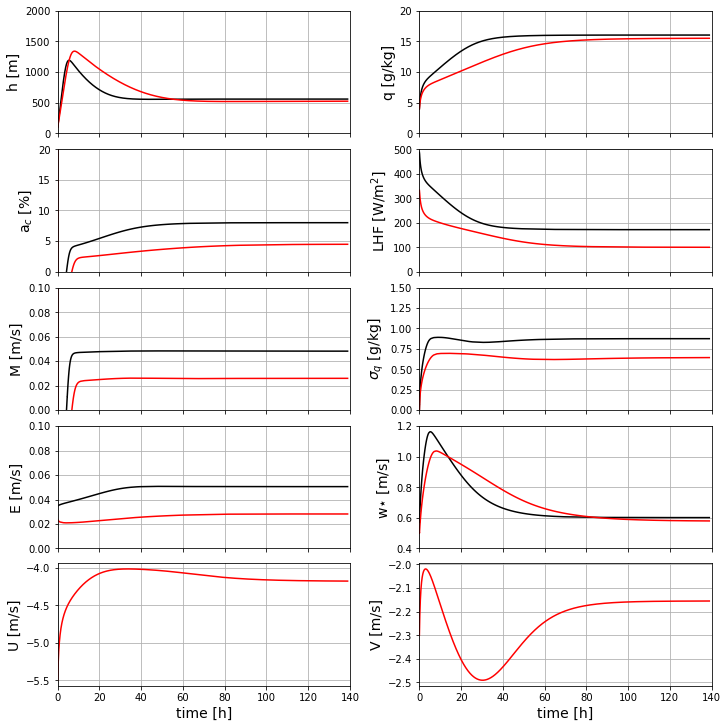

In [15]:
# Plots for a single run.
h = sol.y[0]
q = sol.y[1]
th = sol.y[2]
U = sol.y[3]
V = sol.y[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final = np.max(sol.t)
dt = t_final/3600/len(E_ext) # [h]
time_ext = np.arange(len(E_ext))*dt

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(area_c_ext[-1]*100)+'%')
print('equilibrium w$\star$ = '+str(w_star_ext[-1])+' m/s')

fig, ax = plt.subplots(5,2,figsize=(10,10),sharex=True,constrained_layout=True)

ax[0,0].plot(sol.t/3600,h_CV,'k')
ax[0,0].plot(sol.t/3600,h,'r')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()

ax[0,1].plot(sol.t/3600,q_CV*1e3,'k')
ax[0,1].plot(sol.t/3600,q*1e3,'r')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].set_ylim(0,20)
ax[0,1].grid()

#plt.plot(sol.t/3600,sol.y[2],'.')
#plt.ylabel('th [K]',fontsize=14)
#plt.xlabel('time [h]',fontsize=14)
#plt.grid()
#plt.show()

ax[1,0].plot(time_ext,np.array(area_c_ext_CV)*100,'k')
ax[1,0].plot(time_ext,np.array(area_c_ext)*100,'r')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()

ax[1,1].plot(time_ext,np.array(LHF_ext_CV),'k')
ax[1,1].plot(time_ext,np.array(LHF_ext),'r')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
ax[1,1].set_ylim(0,500)
ax[1,1].grid()

ax[2,0].plot(time_ext,np.array(M_ext_CV),'k')
ax[2,0].plot(time_ext,np.array(M_ext),'r')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(time_ext,np.array(sigma_q_ext_CV)*1e3,'k')
ax[2,1].plot(time_ext,np.array(sigma_q_ext)*1e3,'r')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

ax[3,0].plot(time_ext,np.array(E_ext_CV),'k')
ax[3,0].plot(time_ext,np.array(E_ext),'r')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].plot(time_ext,np.array(w_star_ext_CV),'k')
ax[3,1].plot(time_ext,np.array(w_star_ext),'r')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[4,0].plot(sol.t/3600,U,'r')
ax[4,0].set_ylabel('U [m/s]',fontsize=14)
#ax[4,0].set_ylim(0,0.10)
ax[4,0].grid()

ax[4,1].plot(sol.t/3600,V,'r')
ax[4,1].set_ylabel('V [m/s]',fontsize=14)
#ax[4,1].set_ylim(0,0.10)
ax[4,1].grid()

ax[4,0].set_xlabel('time [h]',fontsize=14)
ax[4,1].set_xlabel('time [h]',fontsize=14)
ax[4,0].set_xlim(0,140)
ax[4,1].set_xlim(0,140)